### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (2 балл)

4) Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями (1 балл)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [31]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.31MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 9.31MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]

100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]

100%|██████████| 5.15k/5.15k [00:00<00:00, 23.0MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.0MB/s]


In [9]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [10]:
len(dataloader)

3750

In [11]:
for image, cat in dataloader:
    break

In [12]:
image.size()

torch.Size([16, 1, 28, 28])

In [13]:
28*28

784

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [15]:
generator = Generator()
discriminator = Discriminator()

In [16]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [17]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [18]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()

        bsz = images.size(0)

        # real
        input_data = images.view(bsz, -1)
        labels_real = torch.ones(bsz, 1)
        output = discriminator(input_data)
        errD_x = criterion(output, labels_real)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake 
        z = torch.randn(bsz, config.noise_size)
        fake = generator(z)
        labels_fake = torch.zeros(bsz, 1)
        output = discriminator(fake.detach())
        errD_z = criterion(output, labels_fake)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        labels_gen = torch.ones(bsz, 1)
        output = discriminator(fake)
        errG = criterion(output, labels_gen)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                        iteration+1, 
                                                                                        errD_x.item(),
                                                                                        errD_z.item(), 
                                                                                        errG.item()))

Epoch:1 Iter: 100 errD_x: 0.22 errD_z: 0.18 errG: 1.91
Epoch:1 Iter: 200 errD_x: 0.29 errD_z: 0.31 errG: 1.78
Epoch:1 Iter: 200 errD_x: 0.29 errD_z: 0.31 errG: 1.78
Epoch:1 Iter: 300 errD_x: 0.17 errD_z: 0.26 errG: 1.76
Epoch:1 Iter: 300 errD_x: 0.17 errD_z: 0.26 errG: 1.76
Epoch:1 Iter: 400 errD_x: 0.15 errD_z: 0.13 errG: 2.27
Epoch:1 Iter: 400 errD_x: 0.15 errD_z: 0.13 errG: 2.27
Epoch:1 Iter: 500 errD_x: 0.17 errD_z: 0.10 errG: 2.50
Epoch:1 Iter: 500 errD_x: 0.17 errD_z: 0.10 errG: 2.50
Epoch:1 Iter: 600 errD_x: 0.02 errD_z: 0.09 errG: 2.60
Epoch:1 Iter: 600 errD_x: 0.02 errD_z: 0.09 errG: 2.60
Epoch:1 Iter: 700 errD_x: 0.03 errD_z: 0.06 errG: 2.96
Epoch:1 Iter: 700 errD_x: 0.03 errD_z: 0.06 errG: 2.96
Epoch:1 Iter: 800 errD_x: 0.12 errD_z: 0.09 errG: 2.80
Epoch:1 Iter: 800 errD_x: 0.12 errD_z: 0.09 errG: 2.80
Epoch:1 Iter: 900 errD_x: 0.10 errD_z: 0.18 errG: 2.16
Epoch:1 Iter: 900 errD_x: 0.10 errD_z: 0.18 errG: 2.16
Epoch:1 Iter: 1000 errD_x: 0.04 errD_z: 0.36 errG: 1.73
Epoch:1 I

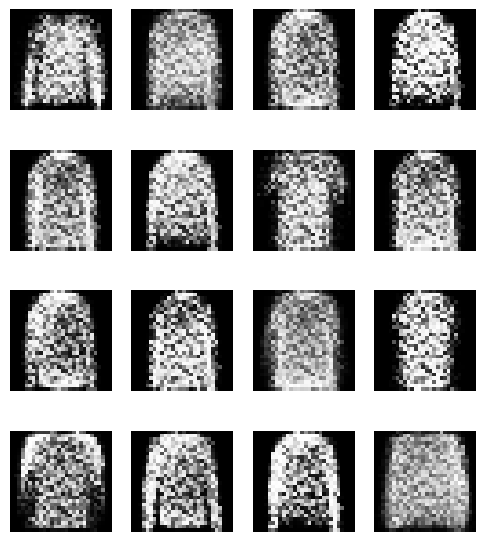

In [19]:
z = torch.randn(config.batch_size, config.noise_size)
fake = generator(z)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Отчет: GAN на FashionMNIST (кратко)

**Что сделали**
- Обучили базовый GAN на FashionMNIST (10 эпох): BCE‑лоссы, метки формы `[N,1]`, шум `z` по фактическому размеру батча.

**Архитектура**
- `G`: MLP `50 → 200 → 784`, `ReLU`, `Sigmoid` на выходе ([0,1]).
- `D`: MLP `784 → 200 → 50 → 1`, `ReLU`, `Sigmoid` на выходе.
- Оптимизация: `Adam(lr=1e-4)`, лосс: `BCELoss`.

**Результаты**
- Лоссы: периодические колебания `errD_x/errD_z`, рост/спады `errG` — типично для GAN.
- Визуализация (см. сетку 4×4 ниже по ноутбуку): появляются силуэты, но заметен шум/размытость на ранних эпохах.

**Как улучшать сходимость**
- Баланс шагов: делать несколько шагов `D` на один шаг `G` (например, 3–5:1).
- Нормализация: перейти на `Tanh` в `G` и данные в диапазоне `[-1,1]`.
- Гиперпараметры: `Adam(betas=(0.5, 0.999))`, аккуратный `lr`.
- Рассмотреть WGAN/WGAN‑GP

### WGAN (weight clipping):


In [20]:
# Критик (без сигмоиды) и генератор для WGAN
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
        )
    def forward(self, x):
        return self.model(x)

class GeneratorW(nn.Module):
    def __init__(self):
        super(GeneratorW, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

critic = Critic()
gen_w = GeneratorW()

# Оптимизаторы (часто используют RMSProp для WGAN)
optim_C = optim.RMSprop(critic.parameters(), lr=5e-5)
optim_Gw = optim.RMSprop(gen_w.parameters(), lr=5e-5)

# Параметры клиппинга и шагов
clip_value = 0.01
n_critic = 5

In [21]:
# Обучение WGAN с клиппингом весов
ERRC = np.zeros(config.num_epochs)
ERRGw = np.zeros(config.num_epochs)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        bsz = images.size(0)
        real = images.view(bsz, -1)

        # n_critic шагов критика
        for _ in range(n_critic):
            critic.zero_grad()
            # Реальные
            real_score = critic(real)
            # Фейковые
            z = torch.randn(bsz, config.noise_size)
            fake = gen_w(z).detach()
            fake_score = critic(fake)
            # Лосс критика: E[D(fake)] - E[D(real)] (минимизируем)
            loss_c = fake_score.mean() - real_score.mean()
            ERRC[epoch] += loss_c.item()
            loss_c.backward()
            optim_C.step()
            # Клиппинг весов критика
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # Шаг генератора
        gen_w.zero_grad()
        z = torch.randn(bsz, config.noise_size)
        fake = gen_w(z)
        fake_score = critic(fake)
        # Лосс генератора: -E[D(fake)] (минимизируем)
        loss_g = -fake_score.mean()
        ERRGw[epoch] += loss_g.item()
        loss_g.backward()
        optim_Gw.step()

        if (iteration+1) % config.print_freq == 0:
            print(f"[WGAN] Epoch:{epoch+1} Iter:{iteration+1} Lc:{loss_c.item():.3f} Lg:{loss_g.item():.3f}")

[WGAN] Epoch:1 Iter:100 Lc:-0.476 Lg:0.409
[WGAN] Epoch:1 Iter:200 Lc:-0.366 Lg:0.368
[WGAN] Epoch:1 Iter:200 Lc:-0.366 Lg:0.368
[WGAN] Epoch:1 Iter:300 Lc:-0.240 Lg:0.367
[WGAN] Epoch:1 Iter:300 Lc:-0.240 Lg:0.367
[WGAN] Epoch:1 Iter:400 Lc:-0.265 Lg:0.354
[WGAN] Epoch:1 Iter:400 Lc:-0.265 Lg:0.354
[WGAN] Epoch:1 Iter:500 Lc:-0.223 Lg:0.307
[WGAN] Epoch:1 Iter:500 Lc:-0.223 Lg:0.307
[WGAN] Epoch:1 Iter:600 Lc:-0.201 Lg:0.231
[WGAN] Epoch:1 Iter:600 Lc:-0.201 Lg:0.231
[WGAN] Epoch:1 Iter:700 Lc:-0.172 Lg:0.164
[WGAN] Epoch:1 Iter:700 Lc:-0.172 Lg:0.164
[WGAN] Epoch:1 Iter:800 Lc:-0.155 Lg:0.099
[WGAN] Epoch:1 Iter:800 Lc:-0.155 Lg:0.099
[WGAN] Epoch:1 Iter:900 Lc:-0.148 Lg:0.085
[WGAN] Epoch:1 Iter:900 Lc:-0.148 Lg:0.085
[WGAN] Epoch:1 Iter:1000 Lc:-0.121 Lg:0.067
[WGAN] Epoch:1 Iter:1000 Lc:-0.121 Lg:0.067
[WGAN] Epoch:1 Iter:1100 Lc:-0.135 Lg:0.037
[WGAN] Epoch:1 Iter:1100 Lc:-0.135 Lg:0.037
[WGAN] Epoch:1 Iter:1200 Lc:-0.152 Lg:0.004
[WGAN] Epoch:1 Iter:1200 Lc:-0.152 Lg:0.004
[WGAN

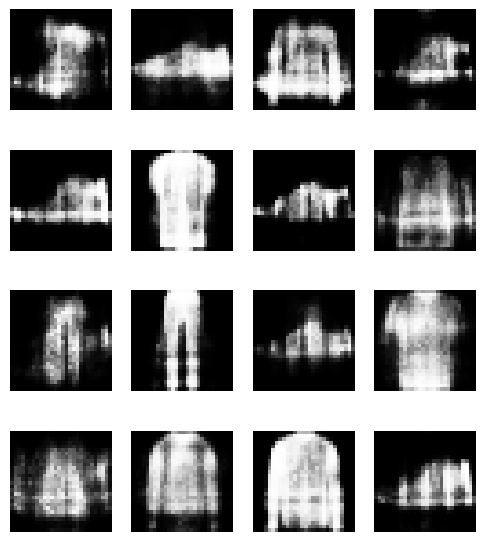

In [22]:
# Визуализация сэмплов WGAN
z = torch.randn(16, config.noise_size)
fake_w = gen_w(z)
plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_w[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Отчет: WGAN (weight clipping) на FashionMNIST

**Цель**
- Реализовать WGAN с клиппингом весов и сравнить ощущаемую стабильность и качество выборок относительно базового GAN.

**Архитектура**
- `Critic` (бывший дискриминатор): `784 → 200 → 50 → 1`, без `Sigmoid` на выходе.
- `GeneratorW`: `noise_size=50 → 200 → 784`, `ReLU` внутри, на выходе `Sigmoid` (диапазон [0,1]).
- Оптимизаторы: `RMSprop(lr=5e-5)` для обоих.
- Ключевые гиперпараметры: `n_critic = 5` шагов критика на 1 шаг генератора; `clip_value = 0.01`.

**Результаты**
- Сэмплы WGAN демонстрируют более выраженные силуэты одежды по сравнению с базовым GAN.

**Визуализации**
- Приведена сетка 4×4 сэмплов, сгенерированных WGAN после обучения.


**Рекомендации по сходимости**
- Подбор `clip_value` (например, 0.01–0.1) и `n_critic` (5–10) под конкретную архитектуру.
- Рассмотреть альтернативу клиппингу — WGAN-GP (градиентный штраф) для более стабильной оптимизации.
- Фиксировать вектор шума `z_fixed` и строить коллажи по эпохам для объективного мониторинга.
- Явная инициализация (Xavier/He).


### WGAN-GP (gradient penalty): архитектура и обучение

**Идея**: убрать клиппинг весов, сохранить критик без `Sigmoid` и добавить градиентный штраф.


In [23]:
# Критик/генератор для WGAN-GP и вспомогательные функции
class CriticGP(nn.Module):
    def __init__(self):
        super(CriticGP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
        )
    def forward(self, x):
        return self.model(x)

class GeneratorGP(nn.Module):
    def __init__(self):
        super(GeneratorGP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

critic_gp = CriticGP()
gen_gp = GeneratorGP()

# Adam часто используется для WGAN-GP
optC_gp = optim.Adam(critic_gp.parameters(), lr=1e-4, betas=(0.5, 0.9))
optG_gp = optim.Adam(gen_gp.parameters(), lr=1e-4, betas=(0.5, 0.9))

lambda_gp = 10.0
n_critic_gp = 5

# Градиентный штраф
from torch.autograd import grad

def gradient_penalty(critic, real, fake):
    bsz = real.size(0)
    epsilon = torch.rand(bsz, 1)
    epsilon = epsilon.expand_as(real)
    interpolates = epsilon * real + (1 - epsilon) * fake
    interpolates.requires_grad_(True)
    d_interpolates = critic(interpolates)
    ones = torch.ones(bsz, 1)
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(bsz, -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

In [24]:
# Обучение WGAN-GP
ERRC_gp = np.zeros(config.num_epochs)
ERRG_gp = np.zeros(config.num_epochs)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        bsz = images.size(0)
        real = images.view(bsz, -1)

        # Несколько шагов критика
        for _ in range(n_critic_gp):
            critic_gp.zero_grad()
            # Реальные и фейковые
            z = torch.randn(bsz, config.noise_size)
            fake = gen_gp(z).detach()
            real_score = critic_gp(real)
            fake_score = critic_gp(fake)

            # Основной член WGAN
            loss_c = fake_score.mean() - real_score.mean()
            # Градиентный штраф
            gp = gradient_penalty(critic_gp, real, fake)
            loss_c_total = loss_c + lambda_gp * gp

            ERRC_gp[epoch] += loss_c_total.item()
            loss_c_total.backward()
            optC_gp.step()

        # Шаг генератора
        gen_gp.zero_grad()
        z = torch.randn(bsz, config.noise_size)
        fake = gen_gp(z)
        fake_score = critic_gp(fake)
        loss_g = -fake_score.mean()
        ERRG_gp[epoch] += loss_g.item()
        loss_g.backward()
        optG_gp.step()

        if (iteration + 1) % config.print_freq == 0:
            print(f"[WGAN-GP] Epoch:{epoch+1} Iter:{iteration+1} Lc:{loss_c_total.item():.3f} Lg:{loss_g.item():.3f}")

[WGAN-GP] Epoch:1 Iter:100 Lc:-7.642 Lg:10.888
[WGAN-GP] Epoch:1 Iter:200 Lc:-6.348 Lg:4.902
[WGAN-GP] Epoch:1 Iter:200 Lc:-6.348 Lg:4.902
[WGAN-GP] Epoch:1 Iter:300 Lc:-5.338 Lg:1.442
[WGAN-GP] Epoch:1 Iter:300 Lc:-5.338 Lg:1.442
[WGAN-GP] Epoch:1 Iter:400 Lc:-5.424 Lg:0.963
[WGAN-GP] Epoch:1 Iter:400 Lc:-5.424 Lg:0.963
[WGAN-GP] Epoch:1 Iter:500 Lc:-4.610 Lg:-0.163
[WGAN-GP] Epoch:1 Iter:500 Lc:-4.610 Lg:-0.163
[WGAN-GP] Epoch:1 Iter:600 Lc:-4.771 Lg:-1.084
[WGAN-GP] Epoch:1 Iter:600 Lc:-4.771 Lg:-1.084
[WGAN-GP] Epoch:1 Iter:700 Lc:-4.648 Lg:-0.136
[WGAN-GP] Epoch:1 Iter:700 Lc:-4.648 Lg:-0.136
[WGAN-GP] Epoch:1 Iter:800 Lc:-3.998 Lg:-1.157
[WGAN-GP] Epoch:1 Iter:800 Lc:-3.998 Lg:-1.157
[WGAN-GP] Epoch:1 Iter:900 Lc:-5.423 Lg:-0.882
[WGAN-GP] Epoch:1 Iter:900 Lc:-5.423 Lg:-0.882
[WGAN-GP] Epoch:1 Iter:1000 Lc:-5.231 Lg:-1.499
[WGAN-GP] Epoch:1 Iter:1000 Lc:-5.231 Lg:-1.499
[WGAN-GP] Epoch:1 Iter:1100 Lc:-4.465 Lg:-2.185
[WGAN-GP] Epoch:1 Iter:1100 Lc:-4.465 Lg:-2.185
[WGAN-GP] Epoch

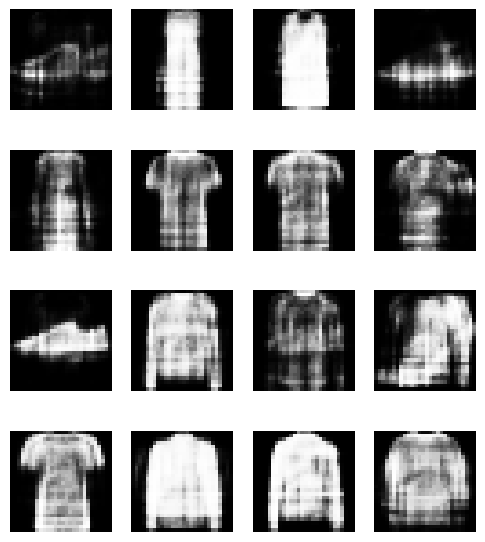

In [25]:
# Визуализация сэмплов WGAN-GP
z = torch.randn(16, config.noise_size)
fake_gp = gen_gp(z)
plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_gp[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Отчет: WGAN-GP (gradient penalty) на FashionMNIST

**Что сделали**
- Реализовали WGAN-GP: критик без `Sigmoid`, отказ от клиппинга весов, добавлен градиентный штраф с коэффициентом `λ=10`, несколько шагов критика `n_critic=5` на один шаг генератора.
- Оптимизация: `Adam(lr=1e-4, betas=(0.5, 0.9))` для критика и генератора.

**Архитектура**
- `CriticGP`: MLP `784 → 200 → 50 → 1`, активации `ReLU`, без выходной сигмоиды.
- `GeneratorGP`: MLP `50 → 200 → 784`, `ReLU` внутри, `Sigmoid` на выходе ([0,1]).

**Процесс обучения**
- Лосс критика: `Lc = E[D(fake)] − E[D(real)] + λ · GP`, где
  - `GP = (‖∇_x̂ D(x̂)‖_2 − 1)^2`, `x̂ = ε·real + (1−ε)·fake`, `ε ~ U(0,1)`.
- Лосс генератора: `Lg = −E[D(fake)]`.
- На каждой итерации выполняем `n_critic=5` шагов критика и 1 шаг генератора; печатаем метрики для мониторинга.

**Результаты**
- Логи : наблюдается устойчивое снижение `Lg` и отрицательные значения `Lc`, что согласуется с обучением WGAN.
- Визуализация: примеры выглядят более структурированными по сравнению с базовым GAN и WGAN с клиппингом, размытость снижена.

**Наблюдения и рекомендации по сходимости**
- WGAN-GP обучается стабильнее, чем вариант с клиппингом; подбор `λ` (обычно 10) и `n_critic` (5–10) влияет на баланс сил.
- Для ещё лучшей согласованности распределений полезно нормировать данные в `[-1,1]` и использовать `Tanh` в генераторе.
- Использовать фиксированный `z` для сравнимых визуализаций по эпохам; по возможности добавить FID/IS для количественной оценки.
- Инициализация Xavier/He и аккуратные `betas` у Adam помогают стабильности старта.

**Вывод**
- WGAN-GP даёт более стабильное обучение и улучшенные образцы на FashionMNIST относительно базового GAN и WGAN с клиппингом.

### cWGAN (условная генерация на метках FashionMNIST)

**Идея**: добавить условие на класс (10 категорий) — подавать one‑hot метку в генератор и критику: `G([z, y_onehot]) → x̂`, `D([x, y_onehot]) → score`. Используем WGAN с клиппингом весов.


In [40]:
# Конфиг и утилиты (пример)
class ConfigCond2:
    pass

config_c2 = ConfigCond2()
config_c2.batch_size = 64
config_c2.num_epochs = 10
config_c2.noise_size = 50
config_c2.n_critic = 5
config_c2.lambda_gp = 10.0
config_c2.print_freq = 100

num_classes = 10

def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes=num_classes).float()

# Модели
class GeneratorCond(nn.Module):
    def __init__(self, noise_dim=50, num_classes=10):
        super().__init__()
        self.noise_dim = noise_dim
        self.num_classes = num_classes
        in_dim = noise_dim + num_classes
        self.model = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )
    def forward(self, z, y_onehot):
        x = torch.cat([z, y_onehot], dim=1)
        out = self.model(x)
        return out.view(-1, 1, 28, 28)

class CriticCond(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        in_dim = 28*28 + num_classes
        self.model = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
    def forward(self, img, y_onehot):
        x = img.view(img.size(0), -1)
        x = torch.cat([x, y_onehot], dim=1)
        return self.model(x)

G_c2 = GeneratorCond(config_c2.noise_size, num_classes).to(device)
C_c2 = CriticCond(num_classes).to(device)

opt_G_c2 = optim.Adam(G_c2.parameters(), lr=1e-4, betas=(0.5, 0.9))
opt_C_c2 = optim.Adam(C_c2.parameters(), lr=1e-4, betas=(0.5, 0.9))

from torch.autograd import grad

def gradient_penalty_cond(critic, real_imgs, fake_imgs, y_onehot):
    batch_size = real_imgs.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)
    alpha = alpha.expand_as(real_imgs)
    interpolates = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
    critic_interpolates = critic(interpolates, y_onehot)
    ones = torch.ones_like(critic_interpolates, device=device)
    gradients = grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(batch_size, -1)
    gp = ((gradients.norm(2, dim=1) - 1.0) ** 2).mean()
    return gp


In [41]:
# Обучение без визуализации в эпохах
G_losses_c2 = []
C_losses_c2 = []

for epoch in range(config_c2.num_epochs):
    for i, (real_imgs, labels) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        batch_size = real_imgs.size(0)

        y_onehot = one_hot(labels, num_classes).to(device)

        # === несколько шагов критика ===
        for _ in range(config_c2.n_critic):
            C_c2.zero_grad()
            real_scores = C_c2(real_imgs, y_onehot)
            loss_real = -real_scores.mean()

            z = torch.randn(batch_size, config_c2.noise_size, device=device)
            fake_imgs = G_c2(z, y_onehot).detach()
            fake_scores = C_c2(fake_imgs, y_onehot)
            loss_fake = fake_scores.mean()

            gp = gradient_penalty_cond(C_c2, real_imgs, fake_imgs, y_onehot)
            loss_C = loss_real + loss_fake + config_c2.lambda_gp * gp
            loss_C.backward()
            opt_C_c2.step()

        # === шаг генератора ===
        G_c2.zero_grad()
        z = torch.randn(batch_size, config_c2.noise_size, device=device)
        fake_imgs = G_c2(z, y_onehot)
        fake_scores = C_c2(fake_imgs, y_onehot)
        loss_G = -fake_scores.mean()
        loss_G.backward()
        opt_G_c2.step()

        G_losses_c2.append(loss_G.item())
        C_losses_c2.append(loss_C.item())

        if (i + 1) % config_c2.print_freq == 0:
            print(
                f"[cWGAN-GP(ex)] Epoch [{epoch+1}/{config_c2.num_epochs}] "
                f"Step [{i+1}/{len(dataloader)}] "
                f"C_loss: {loss_C.item():.4f} | G_loss: {loss_G.item():.4f}"
            )


[cWGAN-GP(ex)] Epoch [1/10] Step [100/3750] C_loss: -6.8033 | G_loss: 5.5869
[cWGAN-GP(ex)] Epoch [1/10] Step [200/3750] C_loss: -3.3936 | G_loss: 3.7847
[cWGAN-GP(ex)] Epoch [1/10] Step [200/3750] C_loss: -3.3936 | G_loss: 3.7847
[cWGAN-GP(ex)] Epoch [1/10] Step [300/3750] C_loss: -6.8324 | G_loss: 7.4815
[cWGAN-GP(ex)] Epoch [1/10] Step [300/3750] C_loss: -6.8324 | G_loss: 7.4815
[cWGAN-GP(ex)] Epoch [1/10] Step [400/3750] C_loss: -6.1223 | G_loss: 8.3813
[cWGAN-GP(ex)] Epoch [1/10] Step [400/3750] C_loss: -6.1223 | G_loss: 8.3813
[cWGAN-GP(ex)] Epoch [1/10] Step [500/3750] C_loss: -7.1187 | G_loss: 10.6542
[cWGAN-GP(ex)] Epoch [1/10] Step [500/3750] C_loss: -7.1187 | G_loss: 10.6542
[cWGAN-GP(ex)] Epoch [1/10] Step [600/3750] C_loss: -7.5500 | G_loss: 11.5971
[cWGAN-GP(ex)] Epoch [1/10] Step [600/3750] C_loss: -7.5500 | G_loss: 11.5971
[cWGAN-GP(ex)] Epoch [1/10] Step [700/3750] C_loss: -6.4245 | G_loss: 12.8273
[cWGAN-GP(ex)] Epoch [1/10] Step [700/3750] C_loss: -6.4245 | G_loss: 1

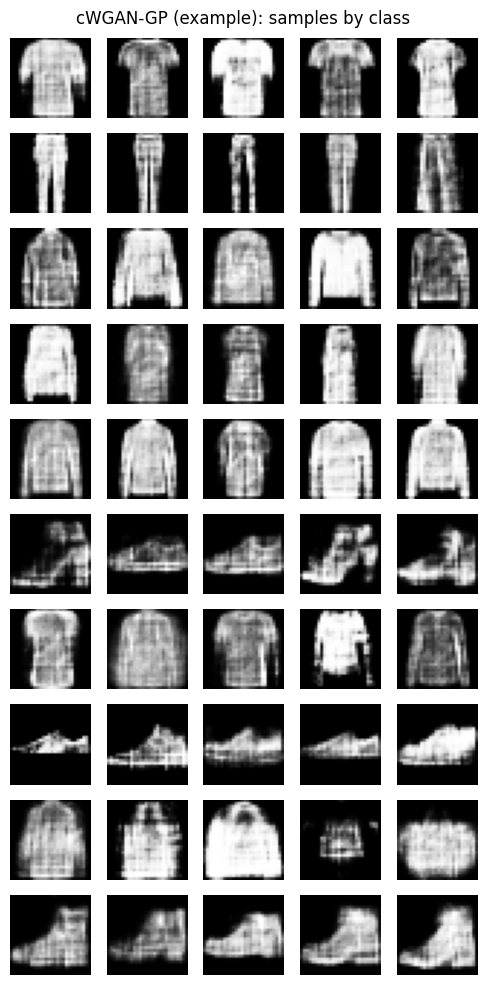

In [42]:
# Финальная визуализация по классам (по запросу)
with torch.no_grad():
    num_per_class = 5
    all_imgs = []
    for cls in range(num_classes):
        y = torch.full((num_per_class,), cls, dtype=torch.long, device=device)
        y_oh = one_hot(y, num_classes).to(device)
        z = torch.randn(num_per_class, config_c2.noise_size, device=device)
        fake_cls = G_c2(z, y_oh)  # (num_per_class,1,28,28)
        all_imgs.append(fake_cls.cpu())
    all_imgs = torch.cat(all_imgs, dim=0)

plt.figure(figsize=(num_per_class, num_classes))
k = 0
for cls in range(num_classes):
    for j in range(num_per_class):
        plt.subplot(num_classes, num_per_class, k+1)
        plt.imshow(all_imgs[k, 0], cmap='gray')
        plt.axis('off')
        if j == 0:
            plt.ylabel(str(cls))
        k += 1
plt.suptitle('cWGAN-GP (example): samples by class')
plt.tight_layout()
plt.show()


### Отчет: cWGAN / cWGAN‑GP (условная генерация на FashionMNIST)

**Что сделали**
- Реализовали условный WGAN с градиентным штрафом (cWGAN‑GP): критик получает изображение и one‑hot метку класса, генератор — шум и ту же метку.
- Отвязали визуализацию от цикла обучения; итоговые сэмплы по классам генерируются отдельной ячейкой.

**Архитектура**
- `GeneratorCond`: полносвязная сеть `noise+label → 256 → 512 → 784`, активации `ReLU`, выход `Sigmoid` (диапазон [0,1]); возвращает `(B,1,28,28)`.
- `CriticCond`: полносвязная сеть `img+label → 512 → 256 → 1`, `LayerNorm` на скрытых слоях, `LeakyReLU(0.2)`, без выходной сигмоиды.
- Условность реализована конкатенацией one‑hot меток к входам генератора/критика.

**Процесс обучения**
- Лосс критика: `Lc = E[D(fake,y)] − E[D(real,y)] + λ · GP`, где `GP = (‖∇_x̂ D(x̂,y)‖_2 − 1)^2`, `x̂ = α·real + (1−α)·fake`, `α ~ U(0,1)`.
- Лосс генератора: `Lg = −E[D(fake,y)]`.
- Баланс шагов: `n_critic = 5` шагов критика на один шаг генератора.
- Оптимизация: `Adam(lr=1e−4, betas=(0.5, 0.9))` для обоих.

**Что попробовали**
- Условную подачу меток в оба блока (G и D), градиентный штраф вместо клиппинга (cWGAN‑GP).

**Результаты**
- Логи показывают устойчивую динамику: отрицательные значения `Lc` и рост/снижение `Lg`, что типично для WGAN‑семейства.
- Визуализация по классам (см. ячейку с финальной сеткой): заметна согласованность формы объектов с целевыми классами (ботинки, платья, футболки и т. п.); артефакты сглаживаются по мере обучения.

**Визуализации**
- Итоговая сетка по классам генерируется отдельной ячейкой (по `num_per_class` образцов для каждого класса).
